# Финальное обучение ансамбля моделей

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')

Device: mps


## Загрузка данных

In [3]:
data = torch.load('../data/Mushrooms_augmented_x7.pt')
images = data['images']
labels = data['labels']

print(f'Images: {images.shape}')
print(f'Labels: {labels.shape}')

Images: torch.Size([46998, 3, 128, 128])
Labels: torch.Size([46998])


In [4]:
dataset = TensorDataset(images, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

g_split = torch.Generator()
g_split.manual_seed(42)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=g_split)

print(f'Train: {train_size}, Test: {test_size}')

Train: 37598, Test: 9400


## Архитектура модели

In [5]:
class ScalableCombinedCNN(nn.Module):
    def __init__(self, channels, num_classes=9, dropout_conv=0.3, dropout_fc=0.5):
        super(ScalableCombinedCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, channels['conv1'], kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels['conv1'])
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_conv)
        
        self.conv2 = nn.Conv2d(channels['conv1'], channels['conv2'], kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels['conv2'])
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout_conv)
        
        self.conv3 = nn.Conv2d(channels['conv2'], channels['conv3'], kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels['conv3'])
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(dropout_conv + 0.1)
        
        self.conv4 = nn.Conv2d(channels['conv3'], channels['conv4'], kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(channels['conv4'])
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(dropout_conv + 0.1)
        
        self.conv5 = nn.Conv2d(channels['conv4'], channels['conv5'], kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(channels['conv5'])
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(dropout_conv + 0.2)
        
        flatten_size = channels['conv5'] * 4 * 4
        self.fc1 = nn.Linear(flatten_size, channels['fc1'])
        self.bn_fc1 = nn.BatchNorm1d(channels['fc1'])
        self.dropout_fc1 = nn.Dropout(dropout_fc + 0.1)
        
        self.fc2 = nn.Linear(channels['fc1'], channels['fc2'])
        self.bn_fc2 = nn.BatchNorm1d(channels['fc2'])
        self.dropout_fc2 = nn.Dropout(dropout_fc)
        
        self.fc3 = nn.Linear(channels['fc2'], num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        return x

In [6]:
best_channels = {
    'conv1': 37,
    'conv2': 72,
    'conv3': 150,
    'conv4': 298,
    'conv5': 614,
    'fc1': 853,
    'fc2': 385
}

## Early Stopping

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0

## Функция обучения

In [8]:
def train_model(seed, channels, dropout_conv, dropout_fc, lr, weight_decay, batch_size, max_epochs=100):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    g_loader = torch.Generator()
    g_loader.manual_seed(seed)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, generator=g_loader)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = ScalableCombinedCNN(channels, dropout_conv=dropout_conv, dropout_fc=dropout_fc).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    print(f'\nTraining model with seed={seed}')
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_running_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        test_loss = test_running_loss / len(test_loader)
        test_acc = 100. * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        scheduler.step(test_loss)
        early_stopping(test_loss, model)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{max_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch+1}')
            model.load_state_dict(early_stopping.best_model)
            break
    
    best_epoch = len(test_losses) - early_stopping.counter
    print(f'Best epoch: {best_epoch}, Test Loss: {early_stopping.best_loss:.4f}, Test Acc: {test_accs[best_epoch-1]:.2f}%')
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'best_epoch': best_epoch,
        'best_test_loss': early_stopping.best_loss,
        'best_test_acc': test_accs[best_epoch-1]
    }

## Обучение 5 моделей

In [9]:
seeds = [42, 100, 200, 300, 400]
models = {}
results = {}

for seed in seeds:
    model, result = train_model(
        seed=seed,
        channels=best_channels,
        dropout_conv=0.3,
        dropout_fc=0.6,
        lr=1e-3,
        weight_decay=1e-5,
        batch_size=64,
        max_epochs=100
    )
    models[seed] = model
    results[seed] = result
    
    if device.type == 'mps':
        torch.mps.empty_cache()

print('\nВсе модели обучены')


Training model with seed=42
Epoch [5/100] Train Loss: 1.4433, Train Acc: 49.26%, Test Loss: 1.3818, Test Acc: 50.65%
Epoch [10/100] Train Loss: 1.1871, Train Acc: 58.61%, Test Loss: 1.1352, Test Acc: 59.71%
Epoch [15/100] Train Loss: 0.9894, Train Acc: 65.68%, Test Loss: 0.9822, Test Acc: 65.05%
Epoch [20/100] Train Loss: 0.8217, Train Acc: 71.39%, Test Loss: 0.7774, Test Acc: 72.37%
Epoch [25/100] Train Loss: 0.7078, Train Acc: 75.42%, Test Loss: 0.7472, Test Acc: 73.24%
Epoch [30/100] Train Loss: 0.6159, Train Acc: 78.70%, Test Loss: 0.6694, Test Acc: 76.34%
Epoch [35/100] Train Loss: 0.4770, Train Acc: 83.58%, Test Loss: 0.6073, Test Acc: 79.29%
Epoch [40/100] Train Loss: 0.3913, Train Acc: 86.38%, Test Loss: 0.6127, Test Acc: 79.28%
Early stopping at epoch 43
Best epoch: 38, Test Loss: 0.5460, Test Acc: 81.27%

Training model with seed=100
Epoch [5/100] Train Loss: 1.4431, Train Acc: 48.98%, Test Loss: 1.4617, Test Acc: 47.65%
Epoch [10/100] Train Loss: 1.2032, Train Acc: 57.75%, 

## Визуализация результатов

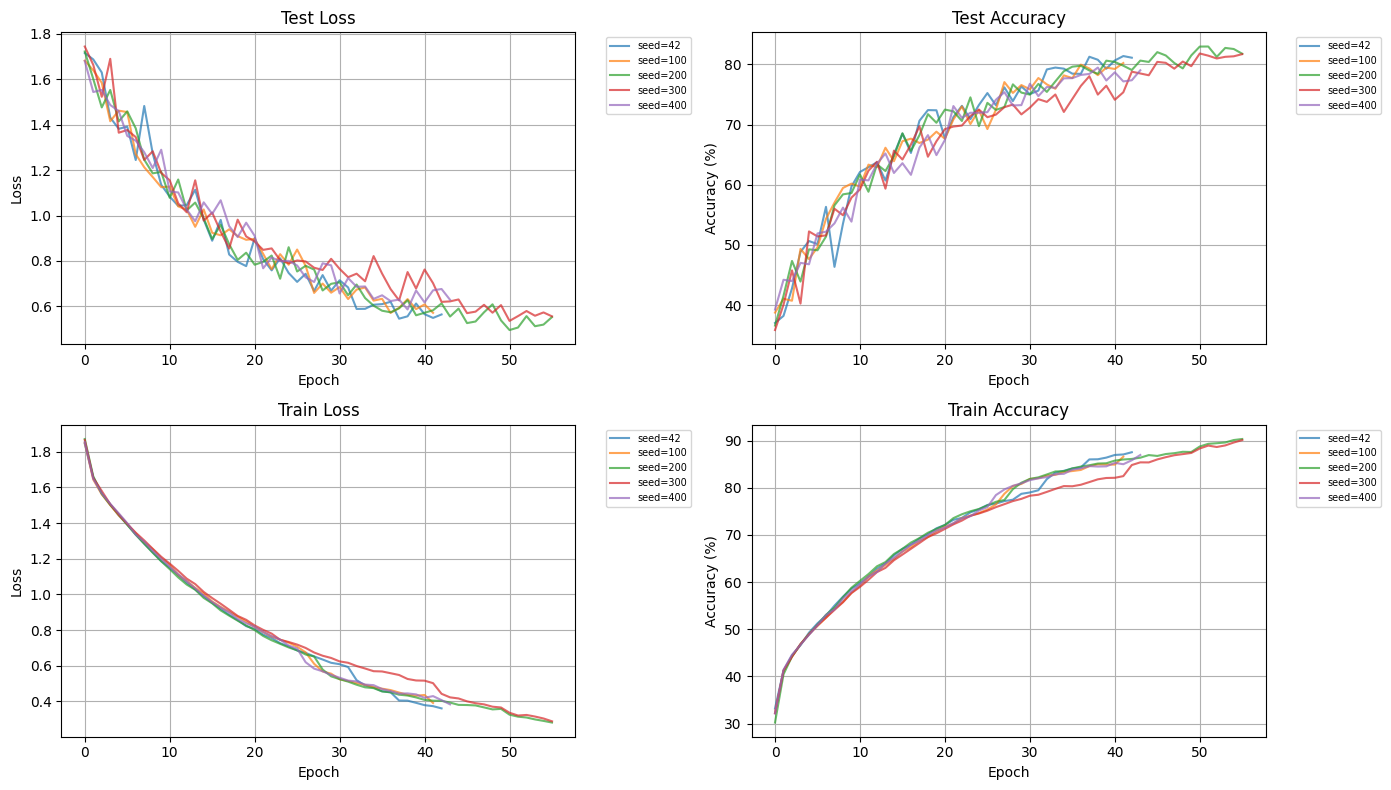

In [10]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
for seed in seeds:
    label = f"seed={seed}"
    plt.plot(results[seed]['test_losses'], label=label, alpha=0.7)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 2)
for seed in seeds:
    label = f"seed={seed}"
    plt.plot(results[seed]['test_accs'], label=label, alpha=0.7)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 3)
for seed in seeds:
    label = f"seed={seed}"
    plt.plot(results[seed]['train_losses'], label=label, alpha=0.7)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 4)
for seed in seeds:
    label = f"seed={seed}"
    plt.plot(results[seed]['train_accs'], label=label, alpha=0.7)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.tight_layout()
plt.show()

## Таблица результатов

In [17]:
print('\nРезультаты отдельных моделей')
print(f'{"Seed":<10} {"Best Epoch":<12} {"Test Loss":<12} {"Test Acc":<10}')
for seed in seeds:
    r = results[seed]
    print(f'{seed:<10} {r["best_epoch"]:<12} {r["best_test_loss"]:<12.4f} {r["best_test_acc"]:<10.2f}%')


Результаты отдельных моделей
Seed       Best Epoch   Test Loss    Test Acc  
42         38           0.5460       81.27     %
100        37           0.5714       79.96     %
200        51           0.4960       82.96     %
300        51           0.5362       81.81     %
400        39           0.5867       79.47     %


## Ensemble evaluation

In [18]:
def ensemble_predict(models, images):
    probs = torch.stack([
        F.softmax(model(images), dim=1) 
        for model in models.values()
    ]).mean(dim=0)
    return probs.argmax(dim=1)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

ensemble_correct = 0
ensemble_total = 0

for model in models.values():
    model.eval()

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = ensemble_predict(models, inputs)
        ensemble_total += targets.size(0)
        ensemble_correct += predictions.eq(targets).sum().item()

ensemble_acc = 100. * ensemble_correct / ensemble_total
print(f'\nEnsemble Accuracy: {ensemble_acc:.2f}%')


Ensemble Accuracy: 83.86%


## Сохранение моделей

In [19]:
ensemble_save = {
    'channels': best_channels,
    'dropout_conv': 0.3,
    'dropout_fc': 0.6,
    'ensemble_acc': ensemble_acc,
}

for seed in seeds:
    ensemble_save[f'seed_{seed}'] = models[seed].state_dict()
    ensemble_save[f'results_{seed}'] = results[seed]

torch.save(ensemble_save, '../data/ensemble_models.pth')
print('\nМодели сохранены в ../data/ensemble_models.pth')


Модели сохранены в ../data/ensemble_models.pth


In [14]:
for seed in seeds:
    torch.save({
        'state_dict': models[seed].state_dict(),
        'channels': best_channels,
        'dropout_conv': 0.3,
        'dropout_fc': 0.6,
        'test_acc': results[seed]['best_test_acc']
    }, f'../data/model_seed{seed}.pth')

print('Отдельные модели сохранены в ../data/model_seed*.pth')

Отдельные модели сохранены в ../data/model_seed*.pth


## Итоговое сравнение

In [20]:
avg_single_acc = sum(r['best_test_acc'] for r in results.values()) / len(results)
improvement = ensemble_acc - avg_single_acc

print(f'Средняя accuracy одной модели: {avg_single_acc:.2f}%')
print(f'Ensemble accuracy: {ensemble_acc:.2f}%')
print(f'Прирост: +{improvement:.2f}%')

Средняя accuracy одной модели: 81.09%
Ensemble accuracy: 83.86%
Прирост: +2.77%
